In [99]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [100]:
def sigma_ij_operator(i, j, states, N, M):
    """placeholder definition"""
    dim = M**N 
    Sigma_ij = np.zeros((dim, dim))

    for k in range(dim):
        for m in range(M):
            for n in range(M):
                if states[k][i] == m and states[k][j] == n:
                    Sigma_ij[k, k] += abs(m - n)  

    return Sigma_ij

def calculate_specific_heat(beta, energy_eigenvalues):
    """placeholder definition"""
    E0 = np.min(energy_eigenvalues)
    E_shifted = energy_eigenvalues - E0

    exp_factors = np.exp(-beta * E_shifted)
    Z_tilde = np.sum(exp_factors)

    avg_E_shifted = np.sum(E_shifted * exp_factors) / Z_tilde
    avg_E2_shifted = np.sum(E_shifted**2 * exp_factors) / Z_tilde

    avg_E = E0 + avg_E_shifted
    avg_E2 = E0**2 + 2 * E0 * avg_E_shifted + avg_E2_shifted

    Cv = (avg_E2 - avg_E**2) * beta**2
    return Cv

def calculate_average_energy(beta, energy_eigenvalues):
    """placeholder definition"""
    E0 = np.min(energy_eigenvalues)
    E_shifted = energy_eigenvalues - E0

    exp_factors = np.exp(-beta * E_shifted)
    Z_tilde = np.sum(exp_factors)

    avg_E_shifted = np.sum(E_shifted * exp_factors) / Z_tilde
    avg_E2_shifted = np.sum(E_shifted**2 * exp_factors) / Z_tilde

    avg_E = E0 + avg_E_shifted
    
    return avg_E


def calculate_finite_temperature_expectation_value(operator, beta, energy_eigenvalues, energy_eigenstates):
    """placeholder definition"""    
    energy_shift = np.min(energy_eigenvalues)
    shifted_energies = energy_eigenvalues - energy_shift

    weights = np.exp(-beta * shifted_energies)
    normalization_factor = np.sum(weights)
    
    expectation_value = 0
    for i, psi in enumerate(energy_eigenstates):
        Ai = psi.T.conj() @ operator @ psi
        expectation_value += weights[i] * Ai

    return expectation_value / normalization_factor


In [101]:
N = 3
M = 5

states, _ = enumerate_states(N,M)

V = 1
mu_V_ratio = 0
J_V_ratio = 1.2042332542542542

hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

# need an operator to test, so let's choose this guy
sigma_01 = sigma_ij_operator(0, 1, states, N, M)

# normalizing by M
sigma_01 = sigma_01/M

In [102]:
ground_state_manifold = construct_ground_state_manifold(eigenvalues, eigenvectors)

average_ground_state_expectation_value = 0
for eigenstate in ground_state_manifold:
    average_ground_state_expectation_value += eigenstate.T.conj() @ sigma_01 @ eigenstate
average_ground_state_expectation_value = average_ground_state_expectation_value/len(ground_state_manifold)

In [103]:
temperatures = np.logspace(-3,3,500)
betas = 1/temperatures
expectation_values = []

for beta in betas:
    expectation_value = calculate_finite_temperature_expectation_value(sigma_01, beta, energy_eigenvalues = eigenvalues, energy_eigenstates = eigenvectors)
    expectation_values += [expectation_value]

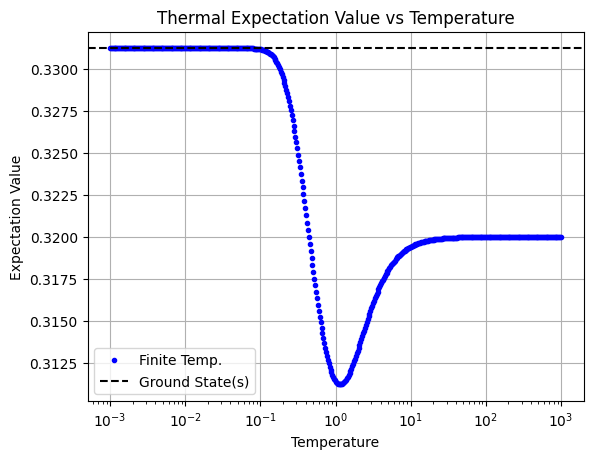

In [104]:
fig, ax = plt.subplots()

ax.plot(temperatures, expectation_values, '.b', label = "Finite Temp.")
ax.axhline(y = average_ground_state_expectation_value, linestyle = "--", color = 'k', label = "Ground State(s)")

ax.set_xscale("log")
ax.set_title("Thermal Expectation Value vs Temperature")
ax.set_xlabel("Temperature")
ax.set_ylabel("Expectation Value")
ax.grid()
ax.legend()

In [115]:
N = 5
M = 3
V = 1
mu_V_ratio = 0.5
J_V_ratios = np.linspace(0.5, 0, 20)

temperatures = np.logspace(-3, 3, 500)
betas = 1 / temperatures
colors = get_cmap("gist_rainbow", len(J_V_ratios))

states, _ = enumerate_states(N, M)

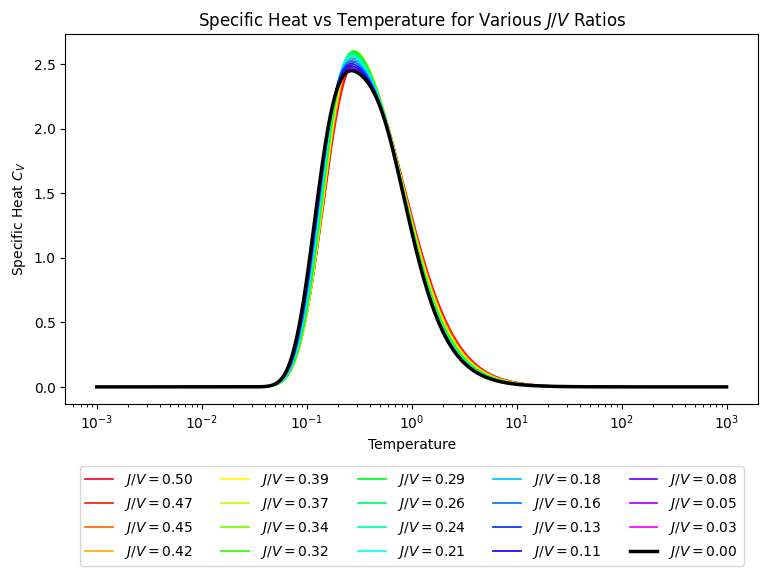

In [116]:
fig, ax = plt.subplots(figsize=(8,6))
for i, J_V_ratio in enumerate(J_V_ratios):
    Cv_values = []
    
    hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    for beta in betas:
        Cv = calculate_specific_heat(beta, eigenvalues)  # Use your shifted version for stability
        Cv_values.append(Cv)
        
    if J_V_ratio == 0:
        color = "k"
        linewidth = 2.5
    else:
        color = colors(i)
        linewidth = 1.25
    
    ax.plot(temperatures, Cv_values, color=color, linewidth = linewidth, label=f"$J/V = {J_V_ratio:.2f}$")

ax.set_xscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("Specific Heat $C_V$")
ax.set_title("Specific Heat vs Temperature for Various $J/V$ Ratios")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()

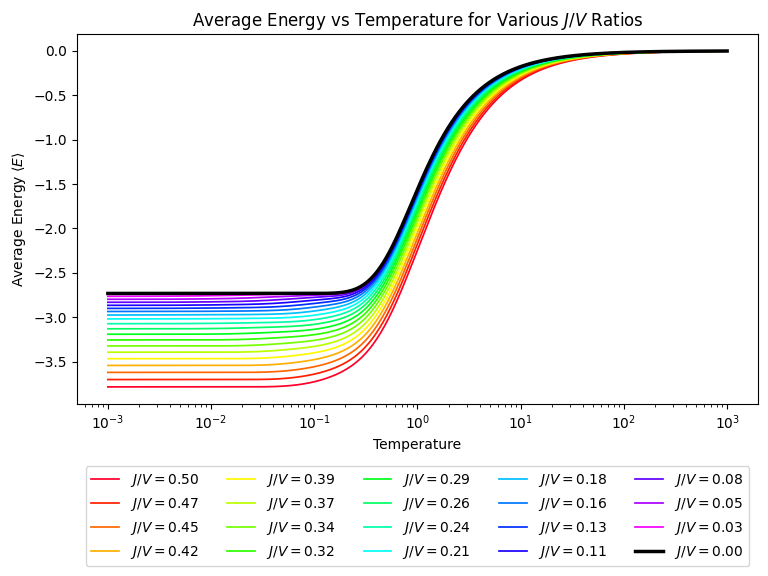

In [113]:
fig, ax = plt.subplots(figsize=(8, 6))
for i, J_V_ratio in enumerate(J_V_ratios):
    average_energies = []
    
    hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    for beta in betas:
        average_energy = calculate_average_energy(beta, eigenvalues)  
        average_energies.append(average_energy)
        
    if J_V_ratio == 0:
        color = "k"
        linewidth = 2.5
    else:
        color = colors(i)
        linewidth = 1.25
    
    ax.plot(temperatures, average_energies, color=color, linewidth = linewidth, label=f"$J/V = {J_V_ratio:.2f}$")

ax.set_xscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("Average Energy $\langle E \\rangle$")
ax.set_title("Average Energy vs Temperature for Various $J/V$ Ratios")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()

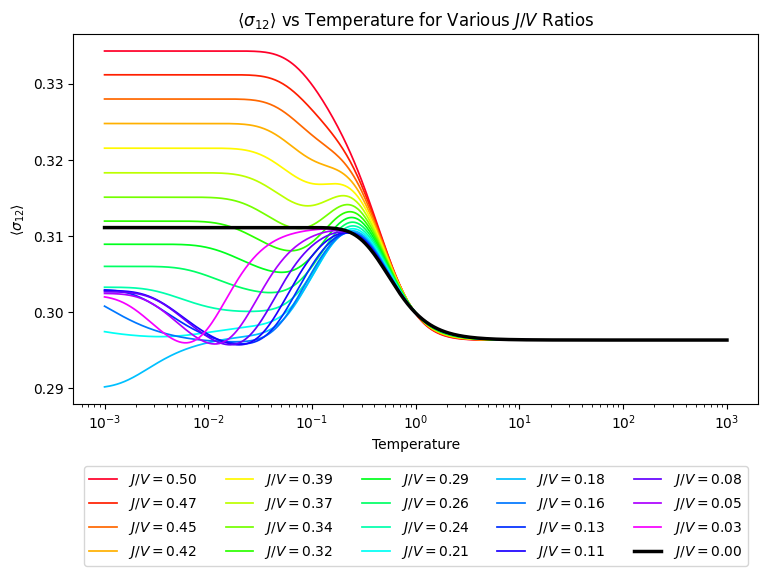

In [114]:
sigma_12 = sigma_ij_operator(0, 4, states, N, M)
sigma_12 = sigma_12/M

fig, ax = plt.subplots(figsize=(8, 6))
for i, J_V_ratio in enumerate(J_V_ratios):
    expectation_values = []
    
    hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    for beta in betas:
        expectation_value = calculate_finite_temperature_expectation_value(sigma_01, beta, eigenvalues, eigenvectors)  
        expectation_values.append(expectation_value)
        
    if J_V_ratio == 0:
        color = "k"
        linewidth = 2.5
    else:
        color = colors(i)
        linewidth = 1.25
    
    ax.plot(temperatures, expectation_values, color=color, linewidth = linewidth, label=f"$J/V = {J_V_ratio:.2f}$")

ax.set_xscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("$\langle \sigma_{12} \\rangle$")
ax.set_title("$\langle \sigma_{12} \\rangle$ vs Temperature for Various $J/V$ Ratios")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()

In [109]:
"""# Parameters
N = 3
M = 5
V = 1
mu_V_ratio = 0

# Get states
states, _ = enumerate_states(N, M)

# Operators
sigma_01 = sigma_ij_operator(0, 1, states, N, M) / M

# Sweep ranges
J_V_ratios = np.linspace(0, 2, 100)
temperatures = np.logspace(-3, 3, 100)

# Prepare expectation value map
expectation_map = np.zeros((len(temperatures), len(J_V_ratios)))

# Compute expectation values
for j, J_V_ratio in enumerate(J_V_ratios):
    for i, temperature in enumerate(temperatures):
        beta = 1 / temperature

        hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        expectation_value = calculate_finite_temperature_expectation_value(
            sigma_01,
            beta,
            energy_eigenvalues=eigenvalues,
            energy_eigenstates=eigenvectors
        )

        expectation_map[i, j] = np.real(expectation_value)  # Ensure real value

# Plot colormap
plt.figure(figsize=(8, 6))

J_grid, T_grid = np.meshgrid(J_V_ratios, temperatures)

c = plt.pcolormesh(J_grid, T_grid, expectation_map, shading='auto', cmap='plasma')
plt.yscale('log')

plt.colorbar(c, label=r'$\langle \sigma_{01} \rangle$')
plt.xlabel(r'$J/V$')
plt.ylabel('Temperature')
plt.title(r'Finite-T Expectation Value of $\sigma_{01}$')

plt.tight_layout()
plt.show()
"""

"# Parameters\nN = 3\nM = 5\nV = 1\nmu_V_ratio = 0\n\n# Get states\nstates, _ = enumerate_states(N, M)\n\n# Operators\nsigma_01 = sigma_ij_operator(0, 1, states, N, M) / M\n\n# Sweep ranges\nJ_V_ratios = np.linspace(0, 2, 100)\ntemperatures = np.logspace(-3, 3, 100)\n\n# Prepare expectation value map\nexpectation_map = np.zeros((len(temperatures), len(J_V_ratios)))\n\n# Compute expectation values\nfor j, J_V_ratio in enumerate(J_V_ratios):\n    for i, temperature in enumerate(temperatures):\n        beta = 1 / temperature\n\n        hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)\n        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)\n\n        expectation_value = calculate_finite_temperature_expectation_value(\n            sigma_01,\n            beta,\n            energy_eigenvalues=eigenvalues,\n            energy_eigenstates=eigenvectors\n        )\n\n        expectation_map[i, j] = np.real(expectation_value)  # Ensure real value\n\n# Plot c